In [1]:
#!pip install git+"https://github.com/soichiro-hattori/tess_cpm"

In [2]:
#pip install scikeras
#pip install tensorflow

This program will contain the ML program that plays around with TESS-CPM data. - testing ground for Dr Ashley's MLP model!


In [1]:
#Load packages :keras, sklearn etc.,
import numpy as np
import pandas as pd
import random
#import torch.utils.data as data
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler


In [2]:
def get_training_data(load=False, datafile ='training_sn_56.npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefiles/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        training_t = []  
        training_f = []
        training_class = []
        training_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(1)
                    training_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(0)
                    training_info.append(info)
        np.savez(datafile,training_t = training_t, training_f = training_f,
                training_class = training_class, training_info = training_info)
        return training_t, training_f,training_class,training_info
    else:
        data = np.load(datafile, allow_pickle=True)
        training_t = data['training_t']         # needs to be padded and then shuffled
        training_f = data['training_f']         
        training_class = data['training_class']  
        training_info = data['training_info']   
        return training_t, training_f,training_class,training_info
training_t, training_f,training_class,training_info = get_training_data(load=True)

In [3]:
#padding. for training_t, and f

#max(map(len, arr)) arr being the array name
max(map(len, training_t))
#min(map(len,training_f))

11766

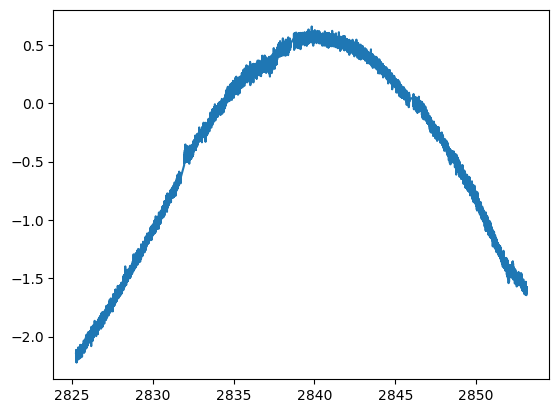

In [4]:
# ploting example LC from training set
plt.plot(training_t[0],training_f[0])

In [5]:
len(training_f)  # to know the length for padding 

3949

In [6]:
#padding the arrays to match the max length
longest_len = 3949
for i in np.arange(len(training_t)):
    mylen = len(training_t[i])
    if mylen>longest_len:
        longest_len = mylen
new_training_t = np.zeros((len(training_t),longest_len))
new_training_f = np.zeros((len(training_t),longest_len))
for i in np.arange(len(training_t)):
    nl = len(training_t[i])
    before_N=int(longest_len/2-(nl/2))
    new_training_t[i,before_N:nl+before_N] = training_t[i]
    new_training_f[i,before_N:nl+before_N] = training_f[i]

In [7]:
#pd.Series(training_f).apply(lambda x: len(x)).idxmax()
len(new_training_t)

3949

In [8]:
#new set with 50/50 SNe
count_arr = np.bincount(training_class)
count1 = count_arr[1]
count0 = count_arr[0]

#get index of 0's, 1's-> np.where 
#np.random.choice?(replace= False ) returns a random sample of zeroes. 

zero=np.where(training_class==0)[0]  # the [0] just means the first "element" in this case array is selected. np.where makes a matrix of size nx2 for some reason 
one = np.where(training_class==1)[0] 
#get the indexes
train_c0 = np.random.choice(zero, size=799, replace=False, p=None)


In [9]:
len(one)

799

In [13]:
train_f0 = new_training_f[train_c0]
train_c00= training_class[train_c0]

train_f1 = new_training_f[one]
train_c11 = training_class[one]

train_c_all = np.append(train_c00,train_c11)
train_f_all = np.vstack((train_f0,train_f1))

In [14]:
#normalizing 
scaler = MinMaxScaler()

xf_all = scaler.fit_transform(train_f_all.T).T


In [15]:
# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
temp = list(zip(train_c_all, xf_all))  # for balanced set is train_c_all, xf_all, # for unblanced or original
random.shuffle(temp)                                                                         # is training_class and new_training_f
train_c_all, xf_all = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
train_c_all, xf_all = np.array(train_c_all), np.array(xf_all)


In [16]:
len(xf_all)

1598

In [17]:
# a balanced training set 

X =xf_all[0:1000]
encoded_Y = train_c_all[0:1000]

#test set 
X_test = xf_all[1001:1598]
Y_test = train_c_all[1001:1598]

In [25]:
X.shape

(1000, 11766)

In [20]:
opt = keras.optimizers.Adam(learning_rate = 0.00001)  #Lr = 0.00001

In [21]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(11766, input_shape=(11766,), activation='relu'))
    model.add(Dense(6000,  activation='relu'))
    model.add(Dense(1800, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [22]:
# evaluate model with standardized dataset
estimator = KerasClassifier(model=create_baseline, epochs=20, batch_size=100, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.20% (1.00%)


In [23]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience = 30)
# change patience 
# play with learning rate 

In [24]:
model = create_baseline() # saves the create_baseline() function in model 

history = model.fit(
x = X,
y = encoded_Y,
batch_size = 100,
epochs = 20,
validation_split = 0.1,
callbacks = [es])


Epoch 1/20
9/9 [==============================] - 34s 3s/step - loss: 0.4278 - accuracy: 0.8144 - val_loss: 0.2107 - val_accuracy: 0.9400
Epoch 2/20
9/9 [==============================] - 23s 3s/step - loss: 0.2532 - accuracy: 0.9111 - val_loss: 0.1333 - val_accuracy: 0.9500
Epoch 3/20
9/9 [==============================] - 26s 3s/step - loss: 0.1904 - accuracy: 0.9311 - val_loss: 0.1090 - val_accuracy: 0.9600
Epoch 4/20
9/9 [==============================] - 21s 2s/step - loss: 0.1918 - accuracy: 0.9267 - val_loss: 0.1167 - val_accuracy: 0.9900
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.1599 - accuracy: 0.9422 - val_loss: 0.0586 - val_accuracy: 0.9800
Epoch 6/20
9/9 [==============================] - 20s 2s/step - loss: 0.1323 - accuracy: 0.9622 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 7/20
9/9 [==============================] - 24s 3s/step - loss: 0.1108 - accuracy: 0.9678 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 8/20
9/9 [==================

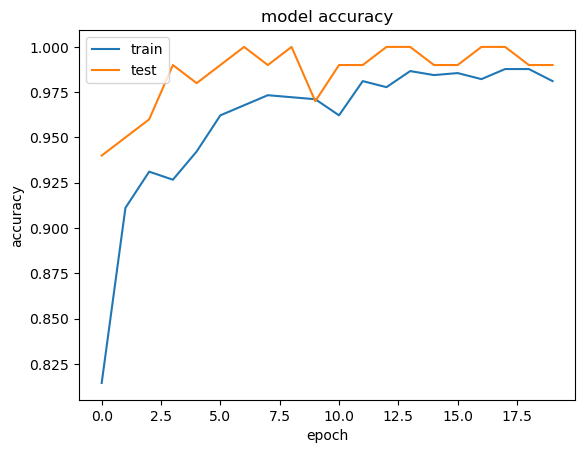

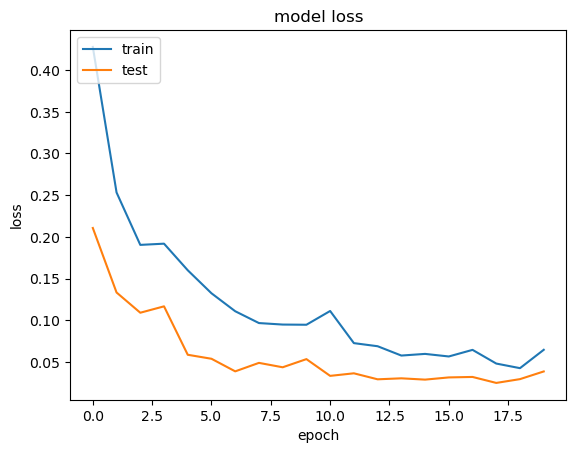

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# testing testing 

model.evaluate(X_test,Y_test)
 

In [ ]:
# more testing - unbalanced data set
X_unb_test = new_training_f
Y_unb_test = training_class

In [ ]:
model.evaluate(X_unb_test, Y_unb_test)


In [ ]:
y_pred_nn = model.predict(X_unb_test)

In [ ]:
plt.hist(y_pred_nn)

In [ ]:
y_pred_nn = np.round(y_pred_nn,0)
y_pred_nn = y_pred_nn.tolist()

In [ ]:
# Some actual testing on SNe = test_sn.npz
#read in the data 
def get_testing_data(load=False, datafile ='test_s56_batch1.npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefile_/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        test_t = []  
        test_f = []
        test_class = []
        test_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(1)
                    test_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(0)
                    test_info.append(info)
        np.savez(datafile,testg_t = test_t, test_f = test_f,
                test_class = test_class, test_info = test_info)
        return test_t, test_f,test_class,test_info
    else:
        data = np.load(datafile, allow_pickle=True)
        test_t = data['training_t']         # needs to be padded and then shuffled
        test_f = data['training_f']         
        test_class = data['training_class']  
        test_info = data['training_info']   
        return test_t, test_f,test_class,test_info
test_t, test_f,test_class,test_info = get_testing_data(load=True)

# evaluate model 

In [ ]:
max(map(len, test_t))

In [ ]:
Xtest = np.array(test_f)
Ytest = np.array(test_class)

longest_len = 11766
for i in np.arange(len(Xtest)): 
    mylen = len(Xtest[i]) 
    if mylen>longest_len:
        longest_len = mylen
new_f = np.zeros((len(Xtest),longest_len)) 
for i in np.arange(len(Xtest)): 
    nl = len(Xtest[i]) 
    before_N=int(longest_len/2-(nl/2))
    new_f[i,before_N:nl+before_N] = Xtest[i]  


In [ ]:
# normalize the fluxes!! Imp step 

xtest = scaler.fit_transform(new_f.T).T

In [ ]:
xtest.shape

In [50]:
ypred = model.predict(xtest)

638/638 [==============================] - 74s 116ms/step


(array([   22.,   103.,   175.,   321.,   540.,   778.,  1318.,  2091.,
         3899., 11151.]),
 array([0.23798233, 0.31388393, 0.38978553, 0.46568713, 0.5415887 ,
        0.6174903 , 0.6933919 , 0.76929355, 0.8451951 , 0.9210967 ,
        0.9969983 ], dtype=float32),
 <BarContainer object of 10 artists>)

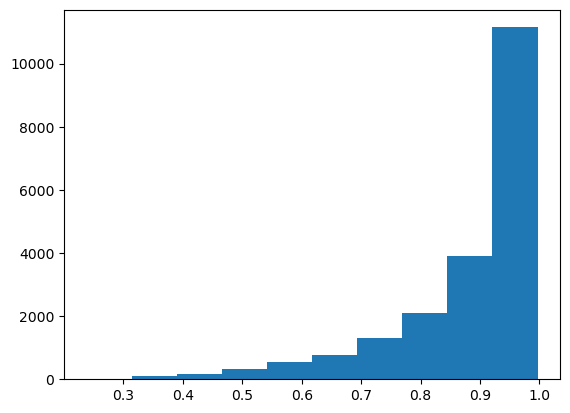

In [51]:
plt.hist(ypred)

In [93]:
 b = np.where(ypred[:,0] <= 0.3)

In [102]:
b

(array([ 6230,  6231,  6236,  6237,  7126,  7127,  7128,  7135,  7136,
         7137,  7138,  7145,  7146, 13689, 18895], dtype=int64),)

In [26]:
#plotting on of the LC that was predicted as a transient
plt.plot(test_t[6230],test_f[6230])
test_info[6230]

NameError: name 'test_t' is not defined

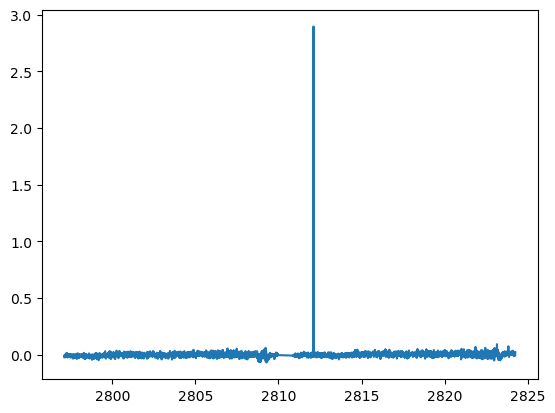

In [111]:
plt.plot(test_t[2617],test_f[2617])

In [52]:
cm = confusion_matrix(Ytest, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

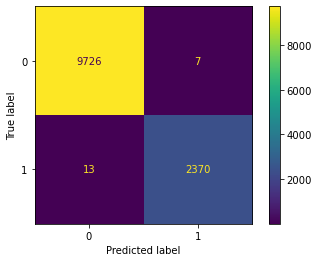

In [44]:
cm = confusion_matrix(Y_unb_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

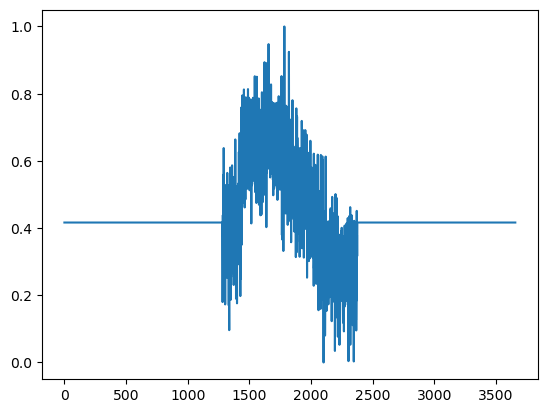

In [62]:
# visualizing .npz plots 
plt.plot(xtest[11])
plt.show()

